#Sales Prediction
## Por: José Guarnizo


##Diccionario de la Base de datos


* Item_Identifier	Número de identificación único del producto
* Item_Weight	Peso del producto
* Item_Fat_Content	Si el producto es bajo en grasas o regular
* Item_Visibility	El porcentaje de área total de visualización de todos los productos en la tienda asignados a este producto particular
* Item_Type	La categoría a la que pertenece el producto
* Item_MRP	Precio Máximo Minorista (precio de lista) del producto
* Outlet_Identifier	Número de identificación único de la tienda
* Outlet_Establishment_Year	El año en el que se estableció la tienda
* Outlet_Size	El tamaño de la tienda en cuanto a la superficie total que cubre
* Outlet_Location_Type	El tipo de área donde se ubica la tienda
* Outlet_Type	Si la tienda es un almacén o algún tipo de supermercado
* Item_Outlet_Sales	Las ventas del producto en la tienda particular. Esta es la * variable objetivo que se debe predecir.

##Importación de librerías y lectura de archivo

In [588]:
pip install category_encoders

In [589]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [590]:
filename='https://raw.githubusercontent.com/JGuarnizo/Sales-Predictions/51d233017c983387a05c8d0f96e793e1913002f6/sales_predictions.csv'


In [591]:
df=pd.read_csv(filename)

## Data Cleaning (Parte 2)

### Inspección del data frame



* Existen 8523 observaciones. 
* Hay 5 variables númericas y 6 categoricas
* Se encuentran 2 variables númericas con datos faltantes. 
** Se obtiene porcentaje de datos faltantes
** 1. Item_Weight (Float) 17.2%
** 2. Outlet_Size (Object) 28.2%
* La variable categórica 'Item_Fat_Content' tiene datos duplicados
** Low Fat = LF, low fat
** Regular = reg

In [592]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [593]:
#Información del data frame
#Existen 2 columnas con datos faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [594]:
#Se obtiene un porcentaje de datos faltantes
round((df.isna().sum()/len(df))*100,1)

Item_Identifier               0.0
Item_Weight                  17.2
Item_Fat_Content              0.0
Item_Visibility               0.0
Item_Type                     0.0
Item_MRP                      0.0
Outlet_Identifier             0.0
Outlet_Establishment_Year     0.0
Outlet_Size                  28.3
Outlet_Location_Type          0.0
Outlet_Type                   0.0
Item_Outlet_Sales             0.0
dtype: float64

In [595]:
#Se explora variable categórica 'Item_Fat_Content' en busca de valores únicos. 
#Se encuentra valores mal declarados repetidos Low Fat = LF lowfat & Regular=reg. 
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [596]:
#Se explora variable categórica 'Item_Type'.
#Todos los valores únicos se encuentran bien declarados
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [597]:
#Se explora variable categórica 'Outlet_Location_Type'.
#Todos los valores únicos se encuentran bien declarados
df['Outlet_Location_Type'].value_counts()


Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

### Rellenar valores Outlet_Size


* La variable Outlet_Size esta ligada a la variable Outlet_Identifier. Por o tanto, se agrupa por Outlet_Identifier y se observa que 3 tiendas no tienen definido su Outlet_Size. La tiendas son: OUT010, OUT017 Y LA OUT045
* Se intenta encontrar alguna relación entre Outlet_Size y Outlet_type para rellenar valores faltantes, pero no hay ninguna relación.
* Si se borran todas las obsrvaciones donde Outlet_Size==NaN entonces se borraría la información de 3 tiendas, por lo tanto no aplica.
* CONCLUSIÓN: Outlet_Size es una variable categórica que no aporta mayor información. Como no se tiene parámetros de como fue creada, se desconoce a que tamaño se refiere Small, Medium o High, y no se tiene relación con ninguna otra variable. Se elimina la variable

In [598]:
#Outlet_Size es el tamaño de cada tienda. Existe un número limitado de tiendas y cada tienda debe tener un tamaño fijo. 
df.groupby(['Outlet_Identifier'])['Outlet_Size','Outlet_Type'].min()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Outlet_Size,Outlet_Type
Outlet_Identifier,,
OUT010,NaN,Grocery Store
OUT013,High,Supermarket Type1
OUT017,NaN,Supermarket Type1
OUT018,Medium,Supermarket Type2
OUT019,Small,Grocery Store
OUT027,Medium,Supermarket Type3
OUT035,Small,Supermarket Type1
OUT045,NaN,Supermarket Type1
OUT046,Small,Supermarket Type1


In [599]:
#No hay relación entre Outlet_Size y (Outlet_Type, Outlet_Location_Type)
df.groupby(['Outlet_Identifier','Outlet_Size','Outlet_Type','Outlet_Location_Type'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)

Outlet_Identifier  Outlet_Size  Outlet_Type        Outlet_Location_Type
OUT027             Medium       Supermarket Type3  Tier 3                  3.453926e+06
OUT035             Small        Supermarket Type1  Tier 2                  2.268123e+06
OUT049             Medium       Supermarket Type1  Tier 1                  2.183970e+06
OUT013             High         Supermarket Type1  Tier 3                  2.142664e+06
OUT046             Small        Supermarket Type1  Tier 1                  2.118395e+06
OUT018             Medium       Supermarket Type2  Tier 3                  1.851823e+06
OUT019             Small        Grocery Store      Tier 1                  1.796941e+05
Name: Item_Outlet_Sales, dtype: float64

In [600]:
df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)

Outlet_Identifier
OUT027    3.453926e+06
OUT035    2.268123e+06
OUT049    2.183970e+06
OUT017    2.167465e+06
OUT013    2.142664e+06
OUT046    2.118395e+06
OUT045    2.036725e+06
OUT018    1.851823e+06
OUT010    1.883402e+05
OUT019    1.796941e+05
Name: Item_Outlet_Sales, dtype: float64

In [601]:
#Se elimina la variable Outlet_Size
df=df.drop(columns=['Outlet_Size'])

###Rellenar valores Item_Weight


* Se obtiene la lista única de Tiendas en la base de datos (Outlet_Identifier). Después, se realiza un filtro para observar cómo se afecta esta lista única de tiendas si se elimina todas las filas donde 'Item_Weight'=NaN. Si se eliminan todos los valores donde Item_Weight==NaN se elimina la información completa de 2 tiendas. Por lo tanto, este enfoque no se aplica

* Se conoce que se tiene el 17% de datos perdidos en la columna Item_Weight, sin embargo, el 'Item_Weight' esta asociado a un 'Item_Identifier', y estos (Item_Identifier) se repiten en varias tiendas, es decir, se puede copiar la información faltante ordenando por Item_Identifier y copiar la información de un producto que se venda en otra tienda.
** Primero, se elimina todas las observaciones que tengan 'Item_Weight'=NaN y su Item_identifier no se repita en otra tienda. Son 4 filas en total
** Segundo, para los valores restantes se ordena el dataframe por Item_Identifier y se copia los valores con el comando fillna(method='bfill').

In [602]:
#Tiendas existentes en la base de datos
#Existen 10 tiendas en total
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [603]:
#Si se decide eliminar todos las observaciones donde Item_Weight==NaN, entonces se eliminaría la información completa de 2 tiendas
#OUT027 & OUT019 ya no aparecen en la base filtrada.
#Por lo tanto, no se puede borrar todas las observaciones donde Item_Weight==NaN
filtro = df['Item_Weight'].isna() 
df.loc[~filtro,:]['Outlet_Identifier'].value_counts()

OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
Name: Outlet_Identifier, dtype: int64

In [604]:
#Se comprueba que existe un valor único de Item_Weight para cada Item_Identifier
#Por lo tanto, existen 4 Item_Identifier que no tienen información de su Item_Weight
total_Item_Identifier=df['Item_Identifier'].value_counts().count()
total_Item_Weight=len(df.groupby(['Item_Identifier'])['Item_Weight'].value_counts())
print('Item_Identifiers sin información de Item_Weight')
print(total_Item_Identifier-total_Item_Weight)

Item_Identifiers sin información de Item_Weight
4


In [605]:
#Se determina cuáles Item_Identifier realmente no tienen Item_Weight
empty_arr=df.groupby(['Item_Identifier'])['Item_Weight'].mean().isna()
empty_weight_item=[]

for i in range(len(empty_arr)):
  if empty_arr[i]==True:
    empty_weight_item.append(empty_arr.index[i])

empty_weight_item

['FDE52', 'FDK57', 'FDN52', 'FDQ60']

In [606]:
#Se crea un filtro para saber cuántos registros con Item_Identifier son iguales a los valores de ['FDE52', 'FDK57', 'FDN52', 'FDQ60']
#Se observa que los 4 items sólo son vendidos en 2 tiendas en la OUT027 & OUT019
filtro_ew=(df['Item_Identifier']==empty_weight_item[0]
        )|(df['Item_Identifier']==empty_weight_item[1]
        )|(df['Item_Identifier']==empty_weight_item[2]
        )|(df['Item_Identifier']==empty_weight_item[3])
#df_ew: df_empty_weight
df_ew=df.loc[filtro_ew,:]

#Se evalúa cuál es el impacto de la venta de esos 4 items en sus repectivas tiendas
#Ventas totales por tienda
total_sales=df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum()
#Porcentaje de ventas de los items de empty_weight_item en sus respectivas tiendas
for i in df_ew.index:  
  ventas_porcentaje=(df_ew.loc[i,'Item_Outlet_Sales']/total_sales[df_ew.loc[i,'Outlet_Identifier']])*100
  print('\nEl item',df_ew.loc[i,'Item_Identifier'],'en la tienda',df_ew.loc[i,'Outlet_Identifier']," representa")
  print('{:.3f}% de sus ventas totales'.format(ventas_porcentaje))


El item FDN52 en la tienda OUT027  representa
0.045% de sus ventas totales

El item FDK57 en la tienda OUT027  representa
0.128% de sus ventas totales

El item FDE52 en la tienda OUT027  representa
0.100% de sus ventas totales

El item FDQ60 en la tienda OUT019  representa
0.067% de sus ventas totales


In [607]:
#Se elimina las 4 observaciones anteriores, debido a que no son relevantes.
df=df.loc[~filtro_ew,:]

In [608]:
#SE RELLENA VALORES ITEM-WEIGHT FALTANTES

#Se crea dataframe con valores faltantes en Item_Weight
df_weigth_null=df.loc[df.Item_Weight.isna(),:]

#Se crea diccionario con valores de Item_Weight para cada Item_Identifier
valores_weight=df.groupby(['Item_Identifier'])['Item_Weight'].mean()
dic_weight={}
for i in valores_weight.index:
  dic_weight[i]=valores_weight[i]
  
#Se reemplaza todos los valores faltantes con los datos del diccionario creado
for i in df_weigth_null.index:
  df.loc[i,'Item_Weight']=dic_weight[df_weigth_null.loc[i,'Item_Identifier']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Corrección de valores duplicados en la columna 'Item_Fat_Content'


* Se corrige valores duplicados en la columna 'Item_Fat_Content'
Se tiene 5 valores únicos ['Low Fat', 'Regular', 'low fat', 'LF', 'reg'] pero sólo deberían haber 2 ['Low Fat', 'Regular']

In [609]:
#Se corrige problema reemplazando valores repetidos
df['Item_Fat_Content'] = np.where(df['Item_Fat_Content']=='low fat', 'Low Fat', df['Item_Fat_Content'])
df['Item_Fat_Content'] = np.where(df['Item_Fat_Content']=='LF', 'Low Fat', df['Item_Fat_Content'])
df['Item_Fat_Content'] = np.where(df['Item_Fat_Content']=='reg', 'Regular', df['Item_Fat_Content'])
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## Análisis de datos

* Variables númericas: 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'
* Lista de tipos de elementos que se venden en las distintas tiendas
* Lista ordenada de mayor a menor de las tiendas que más venden
* Lista ordenada de mayor a menor de los tipos de productos que más se venden.

In [610]:
# Valores mínimos, máximos, desviación estándar de variables numéricas
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* La variable Outlet_Establishment_Year, es el año de apertura de la tienda y no nos aporta mayor información para las ventas.
* La variable Item_Outlet_Sales tiene valores bastante dispersos, pero, es debido a la diferencia de los productos que se vende.


In [611]:
#Obtenemos lista de tipos de elementos que se venden en las distintas tiendas
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [612]:
#Lista ordenada de mayor a menor de los tipos de productos que más se venden.
df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().sort_values(by='Item_Outlet_Sales', ascending=False)

,Item_Outlet_Sales
Item_Type,
Fruits and Vegetables,2.820060e+06
Snack Foods,2.728352e+06
Household,2.055494e+06
Frozen Foods,1.824165e+06
Dairy,1.519141e+06
Canned,1.444151e+06
Baking Goods,1.265405e+06
Health and Hygiene,1.045200e+06
Meat,9.175656e+05


In [613]:
#Lista ordenada de mayor a menor de las tiendas que más venden
df.groupby(['Outlet_Identifier'])[['Item_Outlet_Sales']].sum().sort_values(by='Item_Outlet_Sales', ascending=False)

,Item_Outlet_Sales
Outlet_Identifier,
OUT027,3.444468e+06
OUT035,2.268123e+06
OUT049,2.183970e+06
OUT017,2.167465e+06
OUT013,2.142664e+06
OUT046,2.118395e+06
OUT045,2.036725e+06
OUT018,1.851823e+06
OUT010,1.883402e+05


##Visualización, histogramas y diagramas de caja (Parte 3 y Parte 4)


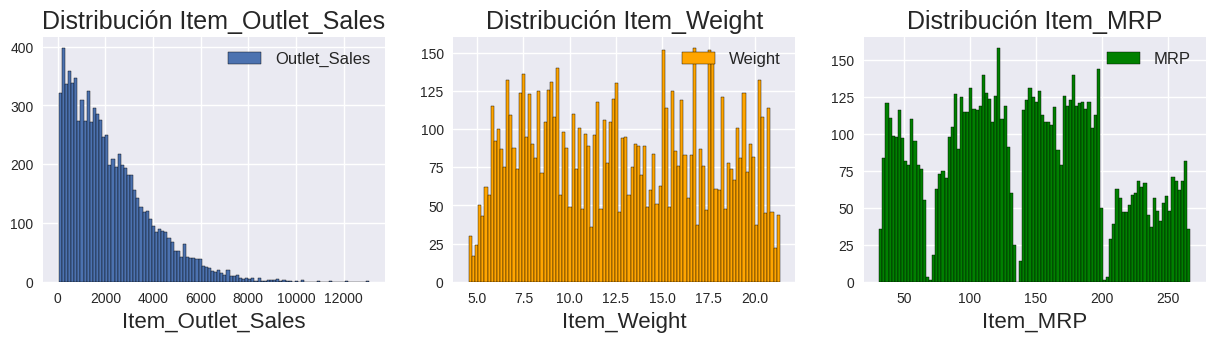

In [614]:
plt.style.use("seaborn")
#Histograma muestra la distribución de 'Item_Outlet_Sales' por items
plt.figure(figsize=(15,7))
item_sales=df['Item_Outlet_Sales']
plt.subplot(2,3,1)
item_sales.hist(bins=100, edgecolor='black',label = 'Outlet_Sales')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Item_Outlet_Sales', fontsize=16)
plt.title('Distribución Item_Outlet_Sales', fontsize=18);

#Histograma que muestra la distribución por peso por items.
item_weight=df['Item_Weight']
plt.subplot(2,3,2)
item_weight.hist(bins=100, edgecolor='black',label = 'Weight', color='orange')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Item_Weight', fontsize=16)
plt.title('Distribución Item_Weight', fontsize=18)

#Histograma que muestra la distribución de las ventas por items.
plt.subplot(2,3,3)
item_mrp=df['Item_MRP']
item_mrp.hist(bins=100, edgecolor='black',label = 'MRP', color='green')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Item_MRP', fontsize=16)
plt.title('Distribución Item_MRP', fontsize=18);

*En la gráfica anterior se observa la distribución de distintas variables.

En el 1er gráfico se observa la distribución de la variable objetivo Item_Outlet_Sales. En el 2do gráfico es la variable Item_Weight y en el 3ro. Item_MRP. Se observa distintas distribuciones entre la grafica 2 y 3 con respecto a la 1, por lo tanto, **las variables Item_Weight y Item_MRP nos aportan información para predecir la variable Item_Outlet_Sales**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

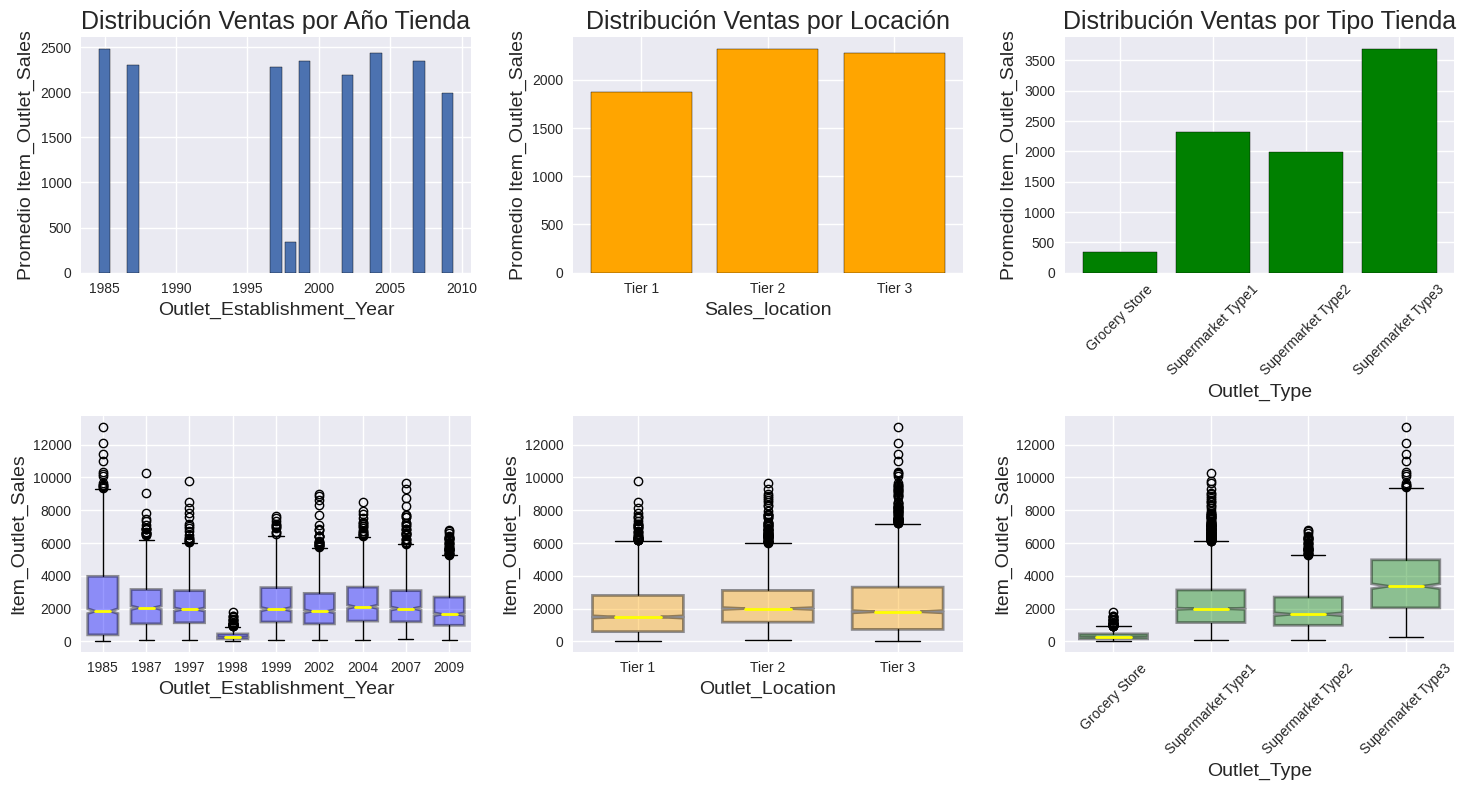

In [615]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8));
#Barras de total 'Item_Outlet_Sales' por Outlet_Establishment_Year
sales_year=df.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].mean()
axes[0,0].bar(sales_year.index, sales_year.values,edgecolor='black',label = 'Outlet_Sales')
axes[0,0].set_xlabel('Outlet_Establishment_Year', fontsize=14)
axes[0,0].set_ylabel('Promedio Item_Outlet_Sales', fontsize=14)
axes[0,0].set_title('Distribución Ventas por Año Tienda', fontsize=18);

#Barras de total 'Item_Outlet_Sales' por Outlet_Location_Type
sales_location=df.groupby(['Outlet_Location_Type'])['Item_Outlet_Sales'].mean()
axes[0,1].bar(sales_location.index, sales_location.values,edgecolor='black',label = 'Outlet_Sales', color='orange')
axes[0,1].set_xlabel('Sales_location', fontsize=14)
axes[0,1].set_ylabel('Promedio Item_Outlet_Sales', fontsize=14)
axes[0,1].set_title('Distribución Ventas por Locación', fontsize=18)

#Barras de total 'Item_Outlet_Sales' por Outlet_Type
sales_outlet_type=df.groupby(['Outlet_Type'])['Item_Outlet_Sales'].mean()
axes[0,2].bar(sales_outlet_type.index, sales_outlet_type.values,edgecolor='black',label = 'Outlet_Sales', color='green')
axes[0,2].tick_params(axis='x', labelrotation=45)
axes[0,2].set_xlabel('Outlet_Type', fontsize=14)
axes[0,2].set_ylabel('Promedio Item_Outlet_Sales', fontsize=14)
axes[0,2].set_title('Distribución Ventas por Tipo Tienda', fontsize=18);

#Diagrama de caja de 'Item_Outlet_Sales' por Outlet_Establishment_Year
sales_by_year=[]
for i in range(0,len(sales_year)):
  sales_by_year.append(df.loc[df.Outlet_Establishment_Year==sales_year.index[i],'Item_Outlet_Sales'])

axes[1,0].boxplot(sales_by_year, labels=sales_year.index, notch = True, widths = .7, patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4));
axes[1,0].set_xlabel('Outlet_Establishment_Year', fontsize=14)
axes[1,0].set_ylabel('Item_Outlet_Sales', fontsize=14)

#Diagrama de caja de 'Item_Outlet_Sales' por Outlet_Location_Type
sales_by_location=[]
for i in range(0,len(sales_location)):
  sales_by_location.append(df.loc[df.Outlet_Location_Type==sales_location.index[i],'Item_Outlet_Sales'])

axes[1,1].boxplot(sales_by_location, labels=sales_location.index, notch = True, widths = .7, patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'orange', alpha = .4));
axes[1,1].set_xlabel('Outlet_Location', fontsize=14)
axes[1,1].set_ylabel('Item_Outlet_Sales', fontsize=14)

##Diagrama de Caja 'Item_Outlet_Sales' por Outlet_Type
sales_by_otype=[]
for i in range(0,len(sales_outlet_type)):
  sales_by_otype.append(df.loc[df.Outlet_Type==sales_outlet_type.index[i],'Item_Outlet_Sales'])

axes[1,2].boxplot(sales_by_otype, labels=sales_outlet_type.index, notch = True, widths = .7, patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'green', alpha = .4));
axes[1,2].tick_params(axis='x', labelrotation=45)
axes[1,2].set_xlabel('Outlet_Type', fontsize=14)
axes[1,2].set_ylabel('Item_Outlet_Sales', fontsize=14);
plt.tight_layout()

* La variable objetivo Item_Outlet_Sales presenta una distribución similar cuando se agrupa por Outlet_Location y Outlet_Establishment_Year, los que no pasa cuando se agrupa por Outlet_Type. **Por lo tanto, las variables Outlet_Location y Outlet_Establishment_Year no aportan información para la predicción de las ventas, los que si hace la variable Outlet_Type**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


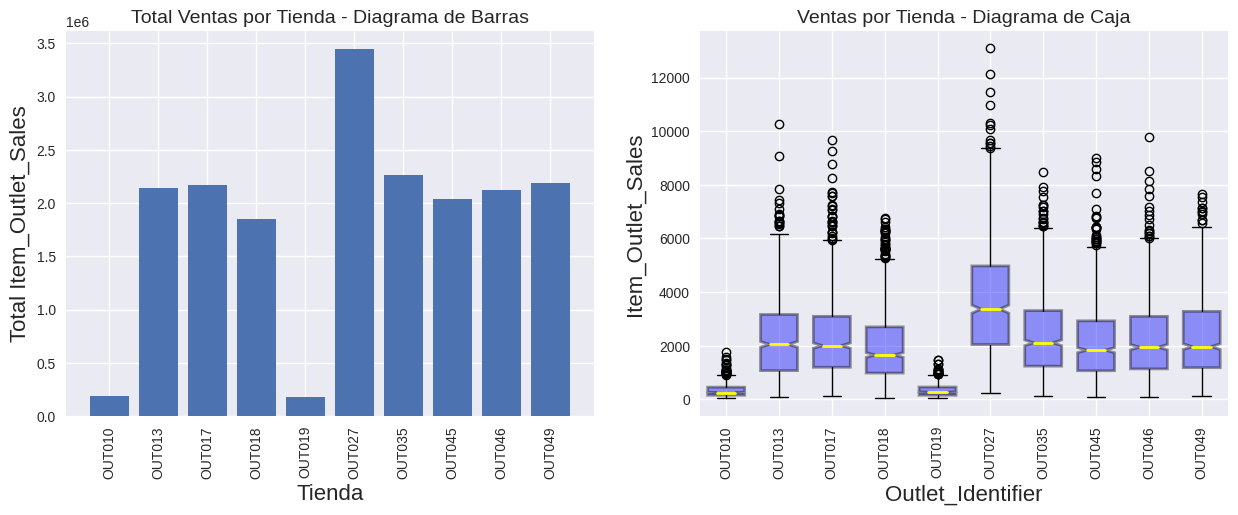

In [616]:
#Barras y Diagrama de Caja
#Muestra la distribución de todas las ventas que tiene cada tienda.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));

total_sales_outlet=df.groupby(['Outlet_Identifier'])[['Item_Outlet_Sales']].sum()

axes[0].bar(total_sales_outlet.index,total_sales_outlet.values.ravel())
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('Tienda', fontsize=16)
axes[0].set_ylabel('Total Item_Outlet_Sales', fontsize=16)
axes[0].set_title('Total Ventas por Tienda - Diagrama de Barras', fontsize=14);

sales_by_outlet=[]
for i in range(0,len(total_sales_outlet)):
  sales_by_outlet.append(df.loc[df.Outlet_Identifier==total_sales_outlet.index[i],'Item_Outlet_Sales'])

axes[1].boxplot(sales_by_outlet, labels=total_sales_outlet.index, notch = True, widths = .7, patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4))
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_xlabel('Outlet_Identifier', fontsize=16)
axes[1].set_ylabel('Item_Outlet_Sales', fontsize=16)
axes[1].set_title('Ventas por Tienda - Diagrama de Caja', fontsize=14);

Si se agrupa por Outlet_Identifier y se obtiene las ventas totales (Barras) se observa que hay diferencia entre en las ventas. Además, al hacer un diagrama de caja de la variable ventas por Outlet_Identifier se observa que la distribución de ventas por tienda es distinta, es decir, **la variable Outlet_identifier si aporta información al Item_Outlet_Sales.**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


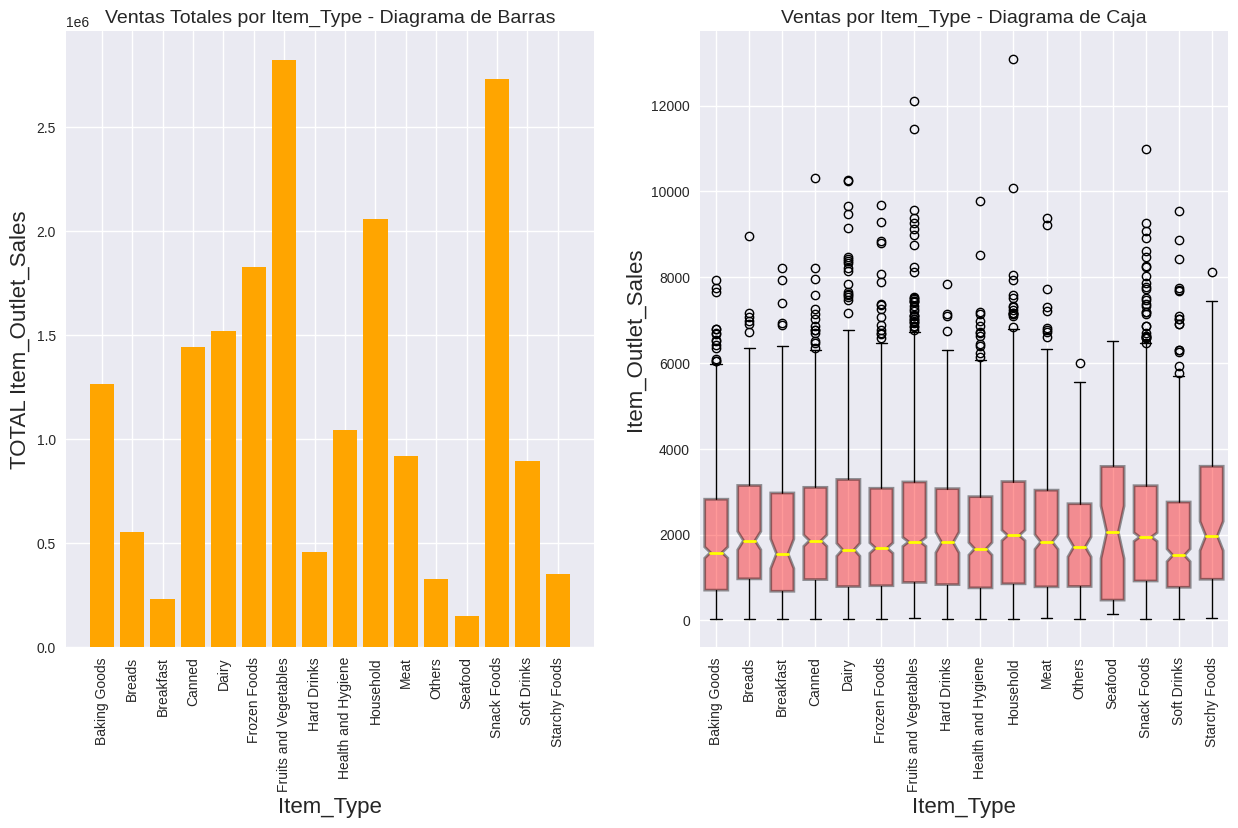

In [617]:
#Barras y Diagrama de caja
#Muestra la distribución de todas las ventas según las categorías de producto.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8));
total_sales_item=df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum()

axes[0].bar(total_sales_item.index, total_sales_item.values.ravel(), color='orange')
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('Item_Type', fontsize=16)
axes[0].set_ylabel('TOTAL Item_Outlet_Sales', fontsize=16)
axes[0].set_title('Ventas Totales por Item_Type - Diagrama de Barras', fontsize=14);

sales_by_item=[]
for i in range(0,len(total_sales_item)):
  sales_by_item.append(df.loc[df.Item_Type==total_sales_item.index[i],'Item_Outlet_Sales'])

axes[1].boxplot(sales_by_item, labels=total_sales_item.index, notch = True, widths = .7,
           patch_artist=True, medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'red', alpha = .4))
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_xlabel('Item_Type', fontsize=16)
axes[1].set_ylabel('Item_Outlet_Sales', fontsize=16);
axes[1].set_title('Ventas por Item_Type - Diagrama de Caja', fontsize=14);

* Si se agrupa por Item_Type y se obtiene las ventas totales (Barras) se observa que hay diferencia entre en las ventas. Sin embargo, al hacer un diagrama de caja de la variable ventas por Item_Type se observa que no hay mayor diferencia entre las medianas y su distribución es similar, es decir, **la variable Item_type no aporta mayor información al Item_Outlet_Sales.**

##Model (Parte 5)


###Preguntas

* **¿Hay algo que puedas hacer para mejorar el modelo?**

Al eliminar las variable 'Item_Type', 'Outlet_Establishment_Year' y  'Outlet_Location_Type' se obtienen mejores resultados en ambos modelos, pero más notorio en el KNN y en la regresión lineal. 

* **¿Qué características están más asociadas con la predicción de ventas mayores?**

La variable 'Item_MRP' (variable numerica, se observa en la matriz de correlación su alto impacto en el target vector), así como la variable 'Outlet_Identifier'(su variabilidad, afecta en gran parte el resultado del target vector). 


###Matriz de correlación, definición de matriz de características y target vector

In [618]:
#Matriz de correlación de variables
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.009173,0.025975,-0.013426,0.013168
Item_Visibility,-0.009173,1.000000,-0.001155,-0.074325,-0.128297
Item_MRP,0.025975,-0.001155,1.000000,0.004599,0.567803
Outlet_Establishment_Year,-0.013426,-0.074325,0.004599,1.000000,-0.049083
Item_Outlet_Sales,0.013168,-0.128297,0.567803,-0.049083,1.000000


In [619]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [620]:
#Matriz de caraterísticas
#Del análisis de datos y visualización de datos, se va a omitir las variables
#'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Item_Type'
 
X=df.drop(columns=['Outlet_Establishment_Year', 'Outlet_Location_Type',
                   'Item_Type','Item_Outlet_Sales', 'Item_Identifier'])
#One Hot Encoder, para lidiar con las variables categóricas.
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_ohe = ohe.fit_transform(X)
X=X_ohe
X.shape

(8519, 19)

In [621]:
#Target Vector
y=df['Item_Outlet_Sales'].values
y.shape

(8519,)

###División Entrenamiento/Prueba (Train/Test)

In [622]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

###Regresión Lineal

In [623]:
#Regresión Lineal
reg=LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)

#Predicciones del modelo
preds_reg = reg.predict(X_test)

#Parámetros de medición, R2, MAE & RMSE
reg_r2 = reg.score(X_test, y_test)
reg_mae = mean_absolute_error(y_test, preds_reg)
reg_rmse = np.sqrt(mean_squared_error(y_test, preds_reg))

###Regresión KNN

In [624]:
#Regresión KNN
#Estandarización de la matriz de características
scaler=StandardScaler()
scaler.fit(X_train)
X1_train=scaler.transform(X_train)
X1_test=scaler.transform(X_test)

In [625]:
#Búsqueda del n_neighbors ideal para lograr el mejor score
neighbors_range_knn = list(range(5, 50, 5))
scores_KNN = []

for neighbor in neighbors_range_knn:
  knn=KNeighborsRegressor(n_neighbors=neighbor)
  knn.fit(X1_train, y_train)
  scores_KNN.append(knn.score(X1_test, y_test))

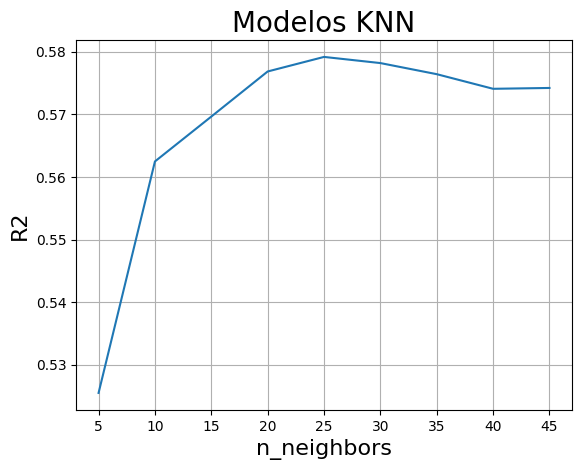

In [626]:
#Gráfica de los distintos modelos KNN con n_neighbors variaando entre 5 a 50
plt.style.use("default")
plt.plot(neighbors_range_knn, scores_KNN)
plt.xlabel('n_neighbors', fontsize =16)
plt.ylabel('R2', fontsize = 16)
plt.title('Modelos KNN', fontsize = 20)
plt.grid();

In [627]:
#De la gráfica anterior, se concluye que n_neighbors para mejor R2 es 25
knn=KNeighborsRegressor(n_neighbors=25)
knn.fit(X1_train,y_train)

#Predicciones del modelo
preds_knn = knn.predict(X1_test)

#Parámetros de medición, R2, MAE & RMSE
knn_r2 = knn.score(X1_test,y_test)
knn_mae = mean_absolute_error(y_test,preds_knn)
knn_rmse = np.sqrt(mean_squared_error(y_test,preds_knn))

###Bosque aleatorio regresión

In [628]:
#Búsqueda del n_estimator para lograr el mejor score
estimator_range_forest = list(range(10, 310, 10))
scores_forest = []

for estimator in estimator_range_forest:
    forest = RandomForestRegressor(n_estimators=estimator, random_state=1, oob_score=True, n_jobs=2)
    forest.fit(X_train, y_train)
    scores_forest.append(forest.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


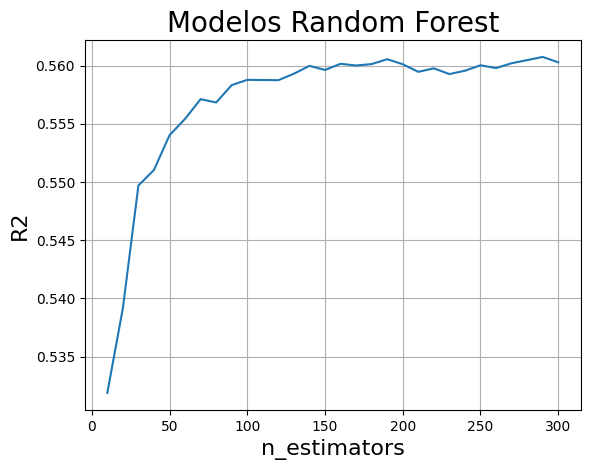

In [629]:
#Gráfica de los distintos random forests con n_estimators variaando entre 10-300
#Se observa mejor resultado con n_estimators=160
plt.plot(estimator_range_forest, scores_forest)
plt.xlabel('n_estimators', fontsize =16)
plt.ylabel('R2', fontsize = 16)
plt.title('Modelos Random Forest', fontsize = 20)
plt.grid();

In [630]:
#De la gráfica anterior, se concluye que n_estimators para mejor R2 es 180
forest = RandomForestRegressor(n_estimators=180, random_state=1, oob_score=True, n_jobs=2)
forest.fit(X_train, y_train)
preds_forest=forest.predict(X_test)

#Parámetros de medición, R2, MAE & RMSE
forest_r2 = forest.score(X_test,y_test)
forest_mae = mean_absolute_error(y_test,preds_forest)
forest_rmse = np.sqrt(mean_squared_error(y_test,preds_forest))

In [631]:
#Se obtiene las 5 características más importantes del modelo random forest 
forest_feature=pd.DataFrame({'feature':X_train.columns, 'feature_importance':forest.feature_importances_})
forest_feature=forest_feature.sort_values(by='feature_importance',ascending=False)
forest_feature[0:6]

,feature,feature_importance
4,Item_MRP,0.457031
17,Outlet_Type_Grocery Store,0.190499
3,Item_Visibility,0.114116
0,Item_Weight,0.092968
18,Outlet_Type_Supermarket Type3,0.041526
9,Outlet_Identifier_OUT027,0.036738


##Resultados (Comparación entre modelos)

In [632]:
#Comparación de resultados
print("SIN variable Item_Identifier - MODELOS FINALES")
print("\tRegresión Lineal\tRegresion KNN (Neighbors=25)\tRandom Forest (Estimator=180)")
print("r2 =\t{:.3f}\t\t\t{:.3f}\t\t\t\t{:.3f}".format(reg_r2,knn_r2,forest_r2))
print("MAE =\t{:.3f}\t\t\t{:.3f}\t\t\t\t{:.3f}".format(reg_mae,knn_mae,forest_mae))
print("RMSE =\t{:.3f}\t\t{:.3f}\t\t\t{:.3f}".format(reg_rmse,knn_rmse,forest_rmse))

SIN variable Item_Identifier - MODELOS FINALES
	Regresión Lineal	Regresion KNN (Neighbors=25)	Random Forest (Estimator=180)
r2 =	0.559			0.579				0.560
MAE =	849.573			794.902				801.058
RMSE =	1130.106		1104.289			1129.002


**SE ELIGE EL MODELO REGRESIÓN KNN (Neighbors=25) ya que obtienen mejores resultados que el Random Forest y el de Regresión Lineal.**